# Case study 1
## Tesla stock prediction 



In [2]:
import numpy as np
import pandas as pd
from pycaret.regression import *
import pandas as pd
import yfinance as yf


In [188]:
# Download additional stock data, which is correlated to Tesla stock, after research we found that NASDAQ is very correlated

tesla_df = yf.download(['TSLA'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
nasdq_df = yf.download(['^IXIC'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
events = pd.read_excel('tesla_tweets.xlsx', sheet_name='tesla_tweets')[['Date', 'stock%']]
events = events[events['stock%']!=0]
nasdq_df.columns = ['Date', 'NSDQ-Open', 'NSDQ-High', 'NSDQ-Low', 'NSDQ-Close', 'NSDQ-Adj Close', 'NSDQ-Volume']
tesla_df.columns = ['Date', 'tesla-Open', 'tesla-High', 'tesla-Low', 'tesla-Close', 'tesla-Adj Close', 'tesla-Volume']
event_tesla_merge = pd.merge(tesla_df, events, how='left', on='Date')
data = pd.merge(event_tesla_merge, nasdq_df, how='left', on='Date')
data['stock%']=data['stock%'].fillna(0)

In [189]:
def date_extraction(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Year'] = pd.DatetimeIndex(dataset['Date']).year
    dataset['Month'] = pd.DatetimeIndex(dataset['Date']).month
    dataset['Day'] = dataset.Date.dt.day
    dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    dataset['Series'] = np.arange(1,len(data)+1)
date_extraction(data)

# 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

## visualization


In [191]:

# plot the data and MA
import plotly.express as px
fig = px.line(data, x="Date", y=["tesla-Close", "NSDQ-Close"], template = 'plotly_dark')
fig.show()


### running preprocessing on our data

# Model pipeline


In [192]:
# split data into train-test set
train = data[data['Date'] < '2021-06-15']
test = data[data['Date'] >= '2021-06-15']
# check shape
train.shape, test.shape

((2127, 20), (11, 20))

In [194]:
train.head()

,Date,tesla-Open,tesla-High,tesla-Low,tesla-Close,tesla-Adj Close,tesla-Volume,stock%,NSDQ-Open,NSDQ-High,NSDQ-Low,NSDQ-Close,NSDQ-Adj Close,NSDQ-Volume,Year,Month,Day,DayOfWeek,WeekOfYear,Series
0,2013-01-02,7.000,7.09,6.942,7.072,7.072,5974000,0.0,3091.330078,3112.649902,3083.489990,3112.260010,3112.260010,2111300000,2013,1,2,2,1,1
1,2013-01-03,7.036,7.09,6.950,6.954,6.954,3710000,0.0,3108.489990,3118.179932,3092.280029,3100.570068,3100.570068,1769420000,2013,1,3,3,1,2
2,2013-01-04,6.960,6.96,6.784,6.880,6.880,3370000,0.0,3100.879883,3108.439941,3090.810059,3101.659912,3101.659912,1745140000,2013,1,4,4,1,3
3,2013-01-07,6.960,6.96,6.780,6.868,6.868,2210000,0.0,3089.169922,3102.350098,3083.879883,3098.810059,3098.810059,1702540000,2013,1,7,0,2,4
4,2013-01-08,6.900,6.90,6.622,6.736,6.736,6420000,0.0,3098.459961,3103.389893,3076.600098,3091.810059,3091.810059,1744380000,2013,1,8,1,2,5


In [196]:
# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = train, train_size=0.7, data_split_shuffle=False, test_data = test, target = 'tesla-Close', 
    fold_strategy = 'timeseries', numeric_features = ['stock%','NSDQ-Close','NSDQ-Open', 'NSDQ-High', 
    'NSDQ-Low', 'NSDQ-Volume', 'Series','tesla-Open', 'tesla-High', 'tesla-Low','tesla-Volume'], 
    feature_interaction=True, 
    categorical_features=  ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear'],
    ignore_low_variance=True,
    remove_multicollinearity=True, multicollinearity_threshold=0.9, 
    fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,tesla-Close
2,Original Data,"(2127, 20)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2127, 236)"


In [197]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,8.8373,617.1740,15.8232,0.8804,0.0562,0.0454,1.7200
en,Elastic Net,9.0332,606.9237,15.8012,0.8623,0.0577,0.0472,0.1267
omp,Orthogonal Matching Pursuit,34.5041,7953.1724,53.1791,0.7380,0.1326,0.0885,1.6267
lr,Linear Regression,19.8711,3271.5378,37.0380,0.1077,0.1294,0.1102,2.6033
et,Extra Trees Regressor,81.9882,40611.5337,120.1030,-0.4755,0.5189,0.2170,1.0600
ada,AdaBoost Regressor,82.3514,40816.3959,120.6673,-0.4912,0.5282,0.2188,0.4200
rf,Random Forest Regressor,82.0648,40631.4416,120.3843,-0.5146,0.5237,0.2171,1.0867
lightgbm,Light Gradient Boosting Machine,82.1644,40734.5794,120.4127,-0.5451,0.5233,0.2164,0.3067
gbr,Gradient Boosting Regressor,81.9697,40502.6657,120.4236,-0.5751,0.5253,0.2184,0.7733
xgboost,Extreme Gradient Boosting,82.2802,40715.3128,120.4626,-0.6375,0.5243,0.2185,1.2733


In [198]:
xgboost = create_model('xgboost', fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2311,21.5761,4.6450,0.5684,0.1079,0.0747
1,1.5849,5.2952,2.3011,0.7900,0.0458,0.0329
2,0.7925,1.0493,1.0244,0.9395,0.0208,0.0163
3,0.5101,0.4230,0.6504,0.9789,0.0155,0.0122
4,5.0214,59.4751,7.7120,0.5555,0.1202,0.0752
5,1.7492,5.0544,2.2482,0.8055,0.0358,0.0282
6,0.9098,1.6395,1.2804,0.9500,0.0200,0.0143
7,0.7400,0.8738,0.9348,0.9863,0.0179,0.0147
8,107.7395,21211.5625,145.6419,-1.1924,0.9013,0.4765
9,241.7876,90295.4609,300.4920,-3.3705,0.5878,0.3433


In [199]:
prediction_holdout = predict_model(xgboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,13.0853,282.6134,16.8111,0.7222,0.0259,0.0199


In [200]:
xgboost = finalize_model(xgboost)
save_model(xgboost, '2022-01-04-xgboost')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Year', 'Month',
                                                             'Day', 'DayOfWeek',
                                                             'WeekOfYear'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['stock%',
                                                           'NSDQ-Close',
                                                           'NSDQ-Open',
                                                           'NSDQ-High',
                                                           'NSDQ-Low',
                                                           'NSDQ-Volume',
                                                           'Series',
                                                        

In [203]:

dataframe = pd.merge(prediction_holdout[['Label', 'tesla-Close']], data[['tesla-Close', 'Date']],  how='inner', on=['tesla-Close'])
dataframe

,Label,tesla-Close,Date
0,602.304932,599.359985,2021-06-15
1,611.445007,604.869995,2021-06-16
2,613.692566,616.599976,2021-06-17
3,618.790833,623.309998,2021-06-18
4,616.687256,620.830017,2021-06-21
5,597.761719,623.710022,2021-06-22
6,632.453857,656.570007,2021-06-23
7,662.676331,679.820007,2021-06-24
8,656.472717,671.869995,2021-06-25
9,654.190857,688.719971,2021-06-28


In [205]:
# line plot
import plotly.graph_objects as go
fig = go.Figure(px.line(dataframe, x='Date', y=["tesla-Close", "Label"], template = 'plotly_dark'), layout_yaxis_range=[580,720])
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2021-06-15", x1="2021-06-29", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

# Feature importance


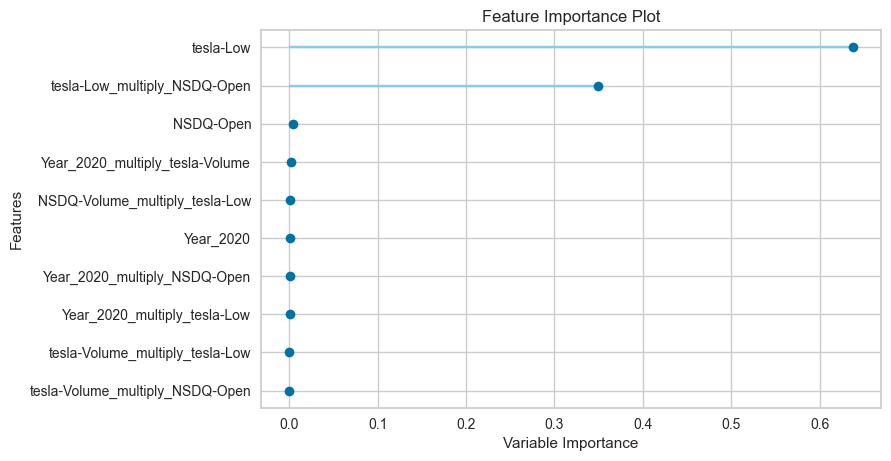

In [206]:
plot_model(xgboost, 'feature')